In [17]:
#@title Imports
import logging
import random
from copy import copy

import random
import platform
from collections import Counter

#from gx_utils import *

In [18]:
#@title Problem instances generator

def problem(N, seed=None):
    """Creates an instance of the problem"""

    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

In [19]:
from traitlets.traitlets import Callable
import itertools

def remove_duplicates(list_):
  list_ = list(k for k,_ in itertools.groupby(list_))

  return list_

def sort_by(list_: list, key: Callable = None):
  list_.sort(key=key)
  return list_
  
def preproc(problem, rem_dup=False, sort=False, f:Callable = None):
  problem= sort_by(problem, key=f)
  problem= remove_duplicates(problem)
  return problem

In [45]:
#@title Problem init & PreProcessing
N = 10

prob_raw = problem(N, seed=42)
prob = preproc(prob_raw)
prob_dim = len(prob)



In [21]:
check_table = list( True for _ in range(0,21))
sum(check_table)

21

In [53]:
from IPython.utils.text import num_ini_spaces
#@title Class & Function Definitions for GA

#@TODO: Work on Checking coverage more efficiently; with N=1000 this seems to be the slowest part of the code
#You can change this to try different fitness function (FF)
def fitness_function(genome):
    """
    This function compute roughly two metrics: the number of used lists and the percentage of integers covered
    it also uses two parameters (Alpha and Beta) to weigth differently the aforementioned metrics
    """

    #First metric
    num_of_lists_taken = sum(genome)

    #Third metric
    num_of_total_numbers = 0

    check_table = list( False for _ in range(0,N))
    #Read all genes in the genome, using an index
    for index in range(0, len(genome)):

      #if the genome at this index is 1, the individual has the index-th list of the problem
      if genome[index] == 1:
        
        #read the number of elements in that list, and add it to the total
        num_of_total_numbers += len(prob[index])

        #then we check for each integer in that list, and we update the checkTable
        for target_integer in range(0,N):
          if target_integer in prob[index]:
            check_table[target_integer] = True
          if all(check_table):
            break
      if all(check_table):
            break
    
    #Second Metric
    values_coverage = ( sum(check_table)/N ) * 100

    #let's try a multi dimensional fitness function 
    #( negative values useful for "Minimizing" without using 1/x which would have requested using sorting on f32)
    return values_coverage, -num_of_total_numbers , -num_of_lists_taken


class Individual():

  def __init__(self, genome=None, fitness_score=None):
    self.genome= genome
    self.fitness_score= fitness_score

  def __str__(self):
    return f"""GENOME: {self.genome}\nFIT_SCORE: {self.fitness_score}"""

  def evaluate(self):
    """
    This function is mainly used as a wrap function, to let us change only the FF and leave the rest
    of the code untouched, using 'evaluate'. It also helps for readability
    """

    self.fitness_score = fitness_function(self.genome)

  def mutate(self, prob=0.1):
    """
    This function simulates mutations over the entire genome. 
    For each gene it tries to mutate with a give probability p.
    The mutation is random between 0 or 1 
    """

    #TODO: check if mutate a single gene with 100% probability is better than this approach

    #for each gene, consider mutate it with a certain probability p
    for gene_index in range(0, len(self.genome)):
      if random.random() < prob:
        #set its value randomly
        self.genome[gene_index] = random.choice([0,1])

def random_new_individual():
  """
  This function create an Individual object
  Genome defined as a bunch of lists from problem
  Fitness score defined using a FF implemented in the 'evaluate' function
  we take a list of value 1 (list taken) or 0 (list NOT taken), each corresponding to a specific list of the problem
  """
  indi = Individual()
  genome = list(random.choice([0,1]) for _ in range(0, prob_dim))   #something like  [0 1 1 0 ... 0 1 1]
  indi.genome = genome
  indi.evaluate()
  return indi

def mate(i1: Individual, i2: Individual) -> Individual:
  """
  Take two indis, randomly cut their genome and then create a new indi with 
  the genome create by the union of the two parts, properly
  """

  indi = Individual()

  cut_index = random.randint(0,len(i1.genome))
  indi.genome = []
  indi.genome[0:cut_index] = i1.genome[0:cut_index]
  indi.genome[cut_index:] = i2.genome[cut_index:]
  indi.mutate()

  return indi

def generate_offspring_from(population: list,
                            p_best_copied=10, 
                            DIM_MAX_OFFSPRING=10_000, 
                            p_mut= 0.1):
  """
  Generates a new list of individuals (INDIS), starting from given 'population'.

  The main idea is to:
  1) select a specific part of the population given a p percentage, as the 'top';
  2) save these top INDIS (added in the offspring during the matin);
  3) let these top INDIS have a mating session at random couple (then extracted), 
     where their direct offspring genome is obtained as a part of the genome of 
     parent 1 and the other part from parent 2. 
  4) the 'child' is then mutated and added to the offspring list, together with both its parents
    NB: parents are extracted from the top_pop list, and added to the offspring

  RECAP:
  The population will be composed by the top p% of the population, and by their offspring, obtained through
  a sort of Recombination/crossover followed by a mutation

  @TODO: Try re-inserting the parents and have N random mating session at couple of even triplet or more 
        (I know it's kinda cringe...)

  @param: population Is the starting point for this function, the list of INDIS
  used to generate the new offspring (OFF).

  @param: p_best_copied Used to select the percentage of the population considered 
  "the best".    
  DEFAULT: 10

  @param: DIM_MAX_OFFSPRING Used to set a Maximum for the dimension of the offspring and avoid
  divergence/explosion of the general population.   
  DEAFULT: 10_000

  @param: p_mut Probability to mutate. It is used to give the 'mutate()' method the probability
  to mutate a gene or not. It must be given as a number in the range [0,1).  
  DEFAULT: 0.1  (10%)

  """

  #Sort by: Coverage, Number of used numbers, Number of used lists
  #Crucial to cut the top p%
  population.sort(key= lambda x: (x.fitness_score[0], x.fitness_score[1], x.fitness_score[2]), reverse=True)

  #get the index corresponding to the p%
  index = int( p_best_copied/100* len(population))

  #divide the population
  top_pop = population[0:index]

  #Maybe useful for future implementations
  bot_pop = population[index:]

  offspring = []

  #Mating Session loop
  while len(top_pop) > 2:
    #Randomly select 2 indis and extract them
    i = random.randint(0, len(top_pop)-1)
    i1 = top_pop.pop(i)
    j = random.randint(0, len(top_pop)-1)
    i2 = top_pop.pop(j)

    #Mate them and obtain the child, mutate it and evaluate
    child = mate(i1, i2)
    child.mutate()
    child.evaluate()

    #Add everyone to the offspring
    offspring.append(i1)
    offspring.append(i2)
    offspring.append(child)

  #Sort crucial for potential Dim Max limit
  offspring.sort(key= lambda x: (x.fitness_score[0], x.fitness_score[1], x.fitness_score[2]), reverse=True)

  if len(offspring) > DIM_MAX_OFFSPRING:
    return offspring[0:DIM_MAX_OFFSPRING]
  return offspring


In [ ]:

#@title Test Functions
i1 = random_new_individual()
i2 = random_new_individual()

i1.evaluate
i2.evaluate

#indi.mutate()
#print(f"MUTATED\nGENOME: {indi.genome}")


print(f"BEFORE REC:\n1) {i1}\n\n2) {i2}")
ci=i1.recombine_with(i2)

print(f"\n\nAFTER REC at {ci}:\n1) {i1}\n\n2) {i2}")

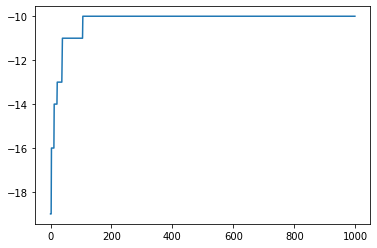

GENOME: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
FIT_SCORE: (100.0, -10, -4)


In [60]:
#@title Population Creation


DIM_POP = 390
#Create an array of Individual istances, each already evaluate
population = [random_new_individual() for _ in range(0, DIM_POP)]
population.sort(key= lambda x: (x.fitness_score[0], x.fitness_score[1], x.fitness_score[2]), reverse=True)

DIM_MAX_OFFSPRING= 700

P = 70 #%
TDIM = 10
NUM_GEN = 1000
P_MUT = 0.45


#Plot variables
best_for_gen = []
gens = range(0,NUM_GEN)

for gen in range(0, NUM_GEN):

  offspring = generate_offspring_from(population, 
                                      p_best_copied=P, 
                                      p_mut = P_MUT, 
                                      DIM_MAX_OFFSPRING=DIM_MAX_OFFSPRING)
  #offspring.sort(key= lambda x: (x.fitness_score[0], x.fitness_score[1], x.fitness_score[2]), reverse=True)
  population = offspring
  best_score = population[0].fitness_score[1]
  best_for_gen.append(best_score)


import matplotlib.pyplot as plt
import numpy as np

plt.plot(gens, best_for_gen)
plt.show()
print(population[0])


In [25]:
print(population[0])

GENOME: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]
FIT_SCORE: (100.0, -11, -10)
